In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.sparse import coo_array
import pandas as pd

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

In [2]:
import CurvilinearFEM_Trial_2D as FEM


In [20]:
'%0.3e'%0.0000000001782301,'%0.3e'%0.0000000002611099

('1.782e-10', '2.611e-10')

In [57]:
H_total=2.0
alphas=[FEM.custom_function_2d_vector(lambda xy:  np.array([(xy[0]+1)**2,(xy[1]+1)**2]),
                                      lambda xy:  np.array([[(xy[0]+1)*2,0],[0,(xy[1]+1)*2]]),
                                 lambda st:  np.array([st[0]**0.5-1,st[1]**0.5-1]),
                                 lambda st:  np.array([[[-0.25*st[0]**(-1.5),0],[0,0]],[[0,0],[0,-0.25*st[1]**(-1.5)]]]),
                          "square"),
        FEM.custom_function_2d_vector(lambda xy: np.array( [(xy[0]+1)**3,(xy[1]+1)**3]),
                                      lambda xy: np.array( [[3*(xy[0]+1)**2,0],[0,3*(xy[1]+1)**2]]),
                                 lambda st: np.array( [st[0]**(1/3)-1,st[1]**(1/3)-1]),
                                 lambda st: np.array( [[[-2/9*st[0]**(-5/3),0],[0,0]],[[0,0],[0,-2/9*st[1]**(-5/3)]]]),
                          "cube"),
        FEM.custom_function_2d_vector(lambda xy:  np.array([xy[0],(xy[1]+1)**2]),
                                      lambda xy: np.array( [[1,0],[0,(xy[1]+1)*2]]),
                          lambda st:  np.array( [st[0],st[1]**0.5-1]), 
                                 lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,-0.25*st[1]**(-1.5)]]]),
                          "Xlinear-Ysquare"),
        FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],xy[1]]),
                                      lambda xy: np.array( [[1,0],[0,1]]),
                                 lambda st: np.array( [st[0],st[1]]),
                                 lambda st:  np.array([[[0,0],[0,0]],[[0,0],[0,0]]]),
                          "identity"),
        FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],np.sin(xy[1])]),
                                      lambda xy: np.array( [[1,0],[0,np.cos(xy[1])]]),
                          lambda st:np.array(   [st[0],np.arcsin(st[1])]), 
                                 lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,st[1]*(1-st[1]**2)**(-1.5)]]]), 
                          "Xlinear-Ysin"),
        FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],(H_total*xy[1]-0.5*xy[1]**2)]),
                                      lambda xy: np.array( [[1,0],[0,H_total-xy[1]]]),
                          lambda st:np.array(   [st[0],H_total-np.sqrt(H_total**2-2*st[1])]), 
                                 lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,(H_total**2-2*st[1])**(-1.5)]]]), 
                          "Xlinear-Ysquare2")]

In [64]:
N_divisions = 10
H_total=2.0
alpha = FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],(H_total*xy[1]-0.5*xy[1]**2)]),
                                      lambda xy: np.array( [[1,0],[0,H_total-xy[1]]]),
                          lambda st:np.array(   [st[0],H_total-np.sqrt(H_total**2-2*st[1])]), 
                                 lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,(H_total**2-2*st[1])**(-1.5)]]]), 
                          "Xlinear-Ysquare2")#RMSE=0.0000000001782301
# alpha =FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],xy[1]]),
#                                       lambda xy: np.array( [[1,0],[0,1]]),
#                                  lambda st: np.array( [st[0],st[1]]),
#                                  lambda st:  np.array([[[0,0],[0,0]],[[0,0],[0,0]]]),
#                           "identity")#RMSE=0.0000000002611099

alpha = [alpha for alpha in alphas if alpha.name=="cube"][0]
print(alpha.name)

cube


In [66]:
def run(N_divisions,alpha,H_total=2.0):
    #Definition of mechanical properties of the continuum
    Youngs_modulus=200*10**9#Pa
    Poisson_Ratio=0.3#0.3# No units
    Rho=7850#kg/m^3
    Lame_mu=Youngs_modulus*0.5/(1+Poisson_Ratio)#Pa
    Lame_lambda=Youngs_modulus*Poisson_Ratio/(1+Poisson_Ratio)/(1-2*Poisson_Ratio)#Pa

    force=Rho*np.array([0,-9.81])


    # Definition of mesh on xy coordinates.
    W, H = 1.0, 1.0
    Nx_divisions = N_divisions
    Ny_divisions = N_divisions

    Nx = Nx_divisions + 1
    Ny = Ny_divisions + 1
    d_x = W/Nx_divisions
    d_y = H/Ny_divisions

    N_nodes=Nx*Ny
    # N_nodes_dummy=Nx_divisions*Ny
    N_ele=Ny_divisions*Nx_divisions

    xy_coor=np.empty((N_nodes,2),float)
    cny=np.empty((N_ele,4),int)


    for i_y in range(Ny):
        xy_coor[i_y*Nx:(i_y+1)*Nx,1]=i_y*d_y

    for i_x in range(Nx):
        xy_coor[i_x::Nx,0]=i_x*d_x

    for i_y in range(Ny_divisions):
        for i_x in range(Nx_divisions):
            i_ele=i_x+i_y*Nx_divisions
            cny[i_ele,0]=i_x   + i_y * Nx
            cny[i_ele,1]=i_x+1 + i_y * Nx
            cny[i_ele,2]=i_x   + (i_y+1) * Nx
            cny[i_ele,3]=i_x+1 + (i_y+1) * Nx

            
    cny_dummy=cny.copy()

    for i_y in range(Ny_divisions):
        cny_dummy[(i_y+1)*Nx_divisions-1,1]=i_y * Nx
        cny_dummy[(i_y+1)*Nx_divisions-1,3]=(i_y+1) * Nx

    st_coor=alpha.function(xy_coor.T).T

    # Gauss points and weights
    # https://en.wikipedia.org/wiki/Gaussian_quadrature
    # gauss_points = (np.array([-np.sqrt(5+2*np.sqrt(10/7))/3,-np.sqrt(5-2*np.sqrt(10/7))/3, 0, 
    #                               np.sqrt(5-2*np.sqrt(10/7))/3,np.sqrt(5+2*np.sqrt(10/7))/3])+1.0)*0.5
    # gauss_weights = np.array([(322-13*np.sqrt(70))/900, (322+13*np.sqrt(70))/900, 128/225, 
    #                           (322+13*np.sqrt(70))/900, (322-13*np.sqrt(70))/900])*0.5
    gauss_points = (np.array([-np.sqrt(3/5), 0,np.sqrt(3/5)])+1.0)*0.5
    gauss_weights = np.array([5/9, 8/9, 5/9])*0.5
    N_gauss_points = gauss_points.size

    # Shape functions : s,t\in[0,1]
    N_nodes_e=4
    N=lambda zeta,eta: np.array([(1-zeta)*(1-eta),  zeta*(1-eta),(1-zeta)*eta,  zeta*eta])
    N_derivatives=lambda zeta,eta: np.array( [ [eta-1,zeta-1],[1-eta,-zeta],[-eta,1-zeta],[eta,zeta]])

    # shape function for boundary
    N_1D=lambda zeta: np.array([1-zeta,  zeta])


    f_vector=np.zeros(N_nodes*2)

    K_row=np.empty((N_ele*(N_nodes_e*2)**2),dtype=int)
    K_col=np.empty((N_ele*(N_nodes_e*2)**2),dtype=int)
    K_values=np.empty((N_ele*(N_nodes_e*2)**2),dtype=float)

    for i_y in range(Ny_divisions):
        for i_x in range(Nx_divisions):
            i_ele=i_y*Nx_divisions+i_x

            # Element 
            node_ids= cny[i_ele]
            node_dummy_ids= cny_dummy[i_ele]
            
            # Element coordinates
            node_coordinates = st_coor[node_ids]

            
            K_e = np.zeros((N_nodes_e*2,N_nodes_e*2))
            f_e = np.zeros(N_nodes_e*2)
            for i_zeta_gauss in range(N_gauss_points):
                for i_eta_gauss in range(N_gauss_points):
                    zeta_gauss = gauss_points[i_zeta_gauss]
                    eta_gauss = gauss_points[i_eta_gauss]

                    N_st=N(zeta_gauss,eta_gauss)

                    s=(node_coordinates[:,0]*N_st).sum()
                    t=(node_coordinates[:,1]*N_st).sum()

                    #prepare collection of variables
                    K_temp = np.zeros((N_nodes_e*2,N_nodes_e*2))
                    F_temp = np.zeros(N_nodes_e*2)

                    # Jacobian # 
                    J = alpha.prime(alpha.inverse((s,t))) # J^st_xy
                    basis_vector_st = np.linalg.inv(J) # e_s,e_t
                    #print(basis_vector_st)
                    inv_det_J=np.linalg.det(basis_vector_st)
                    
                    #Christoffel symbols
                    Gamma = alpha.Christoffel_symbols((s,t))

                    #N_local
                    N_derivatives_st=N_derivatives(zeta_gauss,eta_gauss)
                    J2=np.linalg.inv(N_derivatives_st.T@node_coordinates)
                    
                    #First, gather the epsilons.
                    epsilon_v = np.zeros((N_nodes_e*2,2,2))
                    for i_node in range(N_nodes_e):
                        for j_index in range(2):# j_index = 0(s), 1(t)
                            #                 N_i * Gamma^l_jk (k=s,t, l=x,y)
                            epsilon_v_temp = N_st[i_node] * Gamma[j_index,:,:]
                            #         J^(zeta,eta)_(s,t) [ ∂N_i/∂zeta, ∂N_i/∂eta].T @ [(e_j)x, (e_j)y]
                            epsilon_v_temp += J2@N_derivatives_st[i_node,:,None] @ basis_vector_st[j_index,None,:]
                            epsilon_v_temp = J@epsilon_v_temp
                            epsilon_v[i_node*2+j_index,:,:] = (epsilon_v_temp+epsilon_v_temp.T)*0.5
                    
                        
                    sigma_u = np.zeros((N_nodes_e*2,2,2))
                    for i_node in range(N_nodes_e):
                        for j_index in range(2):#j_index=0(s),1(t)
                            sigma_u[i_node*2+j_index,:,:] = \
                                Lame_lambda*np.trace(epsilon_v[i_node*2+j_index,:,:])*np.eye(2)+\
                                2*Lame_mu*epsilon_v[i_node*2+j_index,:,:]
                    
                    for i_node in range(N_nodes_e*2):
                        for i_node_2 in range(N_nodes_e*2):
                            K_temp[i_node,i_node_2] = np.sum(sigma_u[i_node,:,:]*epsilon_v[i_node_2,:,:])
                    K_e += K_temp*gauss_weights[i_zeta_gauss]*gauss_weights[i_eta_gauss]*d_x*d_y#*inv_det_J
                
                    force_st = basis_vector_st @ force# 2x2, 2x1 -> 2x1 
                    #force_st = J @ force# 2x2, 2x1 -> 2x1 
                    for i_node in range(N_nodes_e):
                        F_temp[i_node*2:i_node*2+2] = N_st[i_node]*force_st
                    f_e += F_temp*gauss_weights[i_zeta_gauss]*gauss_weights[i_eta_gauss]*d_x*d_y#*inv_det_J
                    
            indeces=np.zeros(N_nodes_e*2,dtype=int)
            indeces[0:N_nodes_e*2:2]=node_ids*2
            indeces[1:N_nodes_e*2:2]=node_ids*2+1
            indeces[0:N_nodes_e*2:2]=node_dummy_ids*2
            indeces[1:N_nodes_e*2:2]=node_dummy_ids*2+1

            f_vector[indeces]+=f_e

            i_ele_start=(i_x+i_y*Nx_divisions)*(N_nodes_e*2)**2
            for i in range(N_nodes_e*2):
                for j in range(N_nodes_e*2):
                    K_values[i_ele_start+i*(N_nodes_e*2)+j] = K_e[i,j]
                    K_row[i_ele_start+i*(N_nodes_e*2)+j]    = indeces[i]
                    K_col[i_ele_start+i*(N_nodes_e*2)+j]    = indeces[j]

    K=coo_matrix((K_values, (K_row, K_col)), shape=(N_nodes*2, N_nodes*2)).tocsr()
    #K,f_vector

    N_dofs=N_nodes*2

    #Apply boundary conditions
    #u_known_index=np.zeros(Nt*2,dtype=int)
    u_value=np.zeros(N_dofs,dtype=float)
    u_BC=np.zeros(N_dofs,dtype=int)

    for i in range(1,Ny):
        # Fix the left side (fix x displacement)
        u_value[i*Nx*2]=0
        u_BC[i*Nx*2]=-1

        #Fix the right side (fix x displacement)
        u_value[(i+1)*Nx*2-2]=0
        u_BC[(i+1)*Nx*2-2]=-1

    # Fix the bottom side (fix x and y displacement)
    for i in range(Nx):
        u_value[i*2]=0
        u_value[i*2+1]=0
        u_BC[i*2]=-1
        u_BC[i*2+1]=-1

    # Define cyclic boundary
    for i in range(1,Ny):
        #Fix the right side (fix y displacement as cyclic boundary)
        u_BC[(i+1)*Nx*2-1]=-1

    # Add external forces on the top
    for i_x in np.arange(Nx_divisions):
        i_ele=(Ny_divisions-1)*Nx_divisions+i_x
        # Element 
        node_ids= cny[i_ele][2:]
        node_dummy_ids= cny_dummy[i_ele][2:]

        indeces=np.zeros(2*2,dtype=int)
        indeces[0::2]=node_dummy_ids*2
        indeces[1::2]=node_dummy_ids*2+1
        
        # Element coordinates
        node_coordinates = st_coor[node_ids]
        for i_zeta_gauss in range(N_gauss_points):
            zeta_gauss = gauss_points[i_zeta_gauss]

            N_st=N_1D(zeta_gauss)

            s=(node_coordinates[:,0]*N_st).sum()
            t=(node_coordinates[:,1]*N_st).sum()
            #print(s,t)

            #prepare collection of variables
            F_temp = np.zeros(2*2)

            # Jacobian # 
            x,y=alpha.inverse((s,t))
            #print(x,y)
            J = alpha.prime((x,y)) # J^st_xy
            #print(J)
            basis_vector_st = np.linalg.inv(J) # e_s,e_t
            inv_det_J=np.linalg.det(basis_vector_st)
            

            force_st = basis_vector_st @ force# 2x2, 2x1 -> 2x1 
            #force_st = J @ force# 2x2, 2x1 -> 2x1 
            for i_node in range(2):
                F_temp[i_node*2:i_node*2+2] = N_st[i_node]*force_st
            f_vector[indeces] += F_temp*gauss_weights[i_zeta_gauss]*d_x#*inv_det_J


    N_known=-np.sum(u_BC)
    N_unknown=N_dofs-N_known

    count=0
    for i in range(N_dofs):
        if u_BC[i]!=-1:
            u_BC[i]=count
            count+=1

    A_row=[]
    A_col=[]
    A_values=[]

    b=np.zeros(N_unknown)

    for ind in range(N_dofs):
        i=u_BC[ind]
        if i==-1:
            continue
        b[i]=f_vector[ind]
        for ptr in range(K.indptr[ind],K.indptr[ind+1]):
            i2=K.indices[ptr]
            if u_BC[i2]!=-1:
                if K.data[ptr]==0.0:
                    continue
                A_values.append(K.data[ptr])
                A_row.append(i)
                A_col.append(u_BC[i2])
            else:
                b[i]-=K.data[ptr]*u_value[i2]
        
    A=coo_matrix((A_values, (A_row, A_col)), shape=(N_unknown, N_unknown)).tocsr()
    u_unknown_value=spsolve(A,b)
    u_value[u_BC!=-1]=u_unknown_value

    # update boundary displacements
    for i in range(1,Ny):
        #Fix the right side (fix y displacement as cyclic boundary)
        u_value[(i+1)*Nx*2-1]=u_value[(i)*Nx*2+1]


    f_analytical=lambda x,y: -1/(Lame_lambda+2*Lame_mu)*force[1]*(0.5*y**2-H_total*y)
    u_analytical=np.zeros(N_dofs)
    u_analytical[1::2]=f_analytical(xy_coor[:,0],xy_coor[:,1])

    # adjust the u_value depending the local basis vector.
    e_basis_length=np.zeros((N_nodes,2))
    for i in range(Ny) :
        for j in range(Nx):
            J=alpha.prime(xy_coor[i*Nx+j,:])
            e_basis_length[i*Nx+j,:]=np.linalg.norm(np.linalg.inv(J),axis=0)

    u_value_xy=u_value*e_basis_length.flatten()

    edge_indeces=np.arange(0,N_nodes,Nx)

    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].scatter(xy_coor[edge_indeces,1],u_value_xy[1::2][edge_indeces],label='FEM')
    ax[0].plot(xy_coor[edge_indeces,1],u_analytical[1::2][edge_indeces],label='Analytical')
    ax[0].set_xlabel('y')
    ax[0].set_ylabel('u_xy')
    ax[0].set_title('y displacement on the edge on xy coordinates')
    ax[0].legend()

    # plot u_value and u_analytical
    ax[1].scatter(xy_coor[edge_indeces,1],u_value[1::2][edge_indeces],label='FEM')
    #ax[1].plot(xy_coor[edge_indeces,1],u_analytical[1::2][edge_indeces],label='Analytical')
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('u_st')
    ax[1].set_title('y displacement on the edge on st coordinates')
    ax[1].legend()
    plt.show()

    SE=0.0
    for i_y in range(Ny_divisions):
        for i_x in range(Nx_divisions):
            i_ele=i_y*Nx_divisions+i_x

            # Element 
            node_ids= cny[i_ele]
            
            # Element coordinates
            node_coordinates = st_coor[node_ids]

            e_basis=np.zeros((N_nodes_e,2,2))
            for i,node_id in enumerate(node_ids):
                e_basis[i,:,:]=np.linalg.inv(alpha.prime(xy_coor[node_id,:]))

            indeces=np.zeros(N_nodes_e*2,dtype=int)
            indeces[0:N_nodes_e*2:2]=node_ids*2
            indeces[1:N_nodes_e*2:2]=node_ids*2+1

            u_values_local=u_value[indeces].reshape((4,2))

            SE_local=0.0
            for i_zeta_gauss in range(N_gauss_points):
                for i_eta_gauss in range(N_gauss_points):
                    zeta_gauss = gauss_points[i_zeta_gauss]
                    eta_gauss = gauss_points[i_eta_gauss]

                    N_st=N(zeta_gauss,eta_gauss)
                    u_local=np.einsum('ij,i,ijk->k',u_values_local,N_st,e_basis)

                    s=(node_coordinates[:,0]*N_st).sum()
                    t=(node_coordinates[:,1]*N_st).sum()
                    xy=alpha.inverse((s,t))
                    u_analytical_local=np.array([0,f_analytical(xy[0],xy[1])])
                    SE_local+=((u_local[0]-u_analytical_local[0])**2+(u_local[1]-u_analytical_local[1])**2)*gauss_weights[i_zeta_gauss]*gauss_weights[i_eta_gauss]
            SE+=SE_local*d_x*d_y

    RMSE=np.sqrt(SE/(W*H))
    RMSE

    du=u_value_xy-u_analytical
    # plot u_value and u_analytical
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].scatter(xy_coor[:,1],u_value_xy[1::2],label='FEM')
    ax[0].plot(xy_coor[:,1],u_analytical[1::2],label='Analytical')
    ax[0].set_xlabel('y')
    ax[0].set_ylabel('u')
    ax[0].legend()

    # plot u_value and u_analytical
    ax[1].plot(xy_coor[:,1],du[1::2],label='error')
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('u')
    ax[1].legend()
    plt.show()

    if N_divisions<=20:
        #create the mesh on xy and st plane
        fig, ax = plt.subplots(1,2,figsize=(10,5))

        for i in range(N_ele):
            node_ids=cny[i]
            #print(node_ids)
            for indeces in [(0,1),(1,3),(2,3),(0,2)]:
                #print(node_ids[indeces])
                ax[0].plot(xy_coor[node_ids[indeces,],0],xy_coor[node_ids[indeces,],1],c='black')
                ax[1].plot(st_coor[node_ids[indeces,],0],st_coor[node_ids[indeces,],1],c='black')
        # set the title 
        ax[0].set_title(f'Coordinate system "{alpha.name}" on cartesian')
        ax[1].set_title(f'Coordinate system "{alpha.name}" on st coordinates')
        #fix the aspect ratio
        plt.gca().set_aspect('equal', adjustable='box')
        # set the limit [0,1]^2
        ax[0].set_xlim(0,1)
        ax[0].set_ylim(0,1)
        plt.tight_layout()
        plt.savefig(f'Figure/coor_shape_{alpha.name}_{N_divisions}.png')
        plt.show()

    with open("output_vector.txt", "a") as file:
        # write the N, alpha.name, RMSE in csv format
        file.write(f"{N_nodes},{N_divisions},{alpha.name},{RMSE:0.16f}\n")
    print(f"{N_nodes},{N_divisions},{alpha.name},{RMSE:0.16f}")

alpha.name='square' transformation
N_divisions=5 N_divisions
1.0495887327668736 4.0
0.024494379080175044 1.0
[[2.04898876 0.        ]
 [0.         4.        ]]
1.22 4.0
0.10453610171872607 1.0
[[2.2090722 0.       ]
 [0.        4.       ]]
1.3904112672331264 4.0
0.1791570155128308 1.0
[[2.35831403 0.        ]
 [0.         4.        ]]
1.4986048659972142 4.0
0.2241751778226897 1.0
[[2.44835036 0.        ]
 [0.         4.        ]]
1.6999999999999997 4.0
0.30384048104052974 1.0
[[2.60768096 0.        ]
 [0.         4.        ]]
1.9013951340027855 4.0
0.37891085063639474 1.0
[[2.7578217 0.       ]
 [0.        4.       ]]
2.0276209992275547 4.0
0.4239455745313985 1.0
[[2.84789115 0.        ]
 [0.         4.        ]]
2.2600000000000002 4.0
0.5033296378372909 1.0
[[3.00665928 0.        ]
 [0.         4.        ]]
2.492379000772446 4.0
0.578727019079754 1.0
[[3.15745404 0.        ]
 [0.         4.        ]]
2.6366371324578965 4.0
0.6237725002160543 1.0
[[3.247545 0.      ]
 [0.       4.     

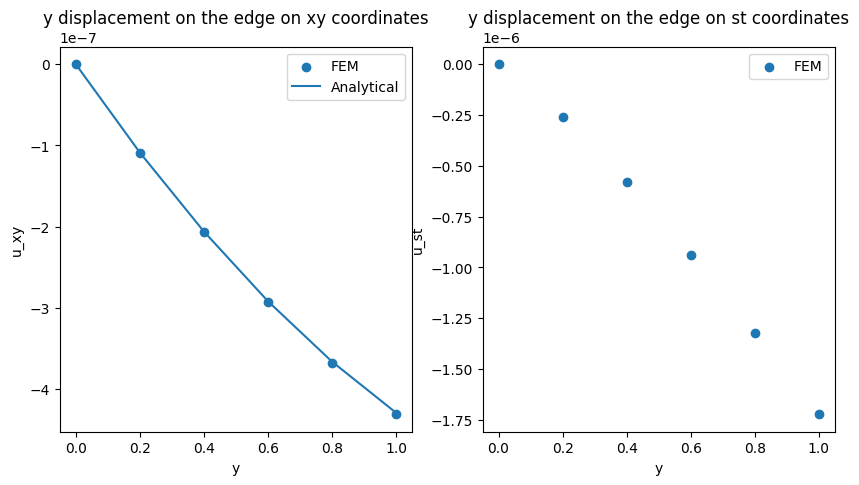

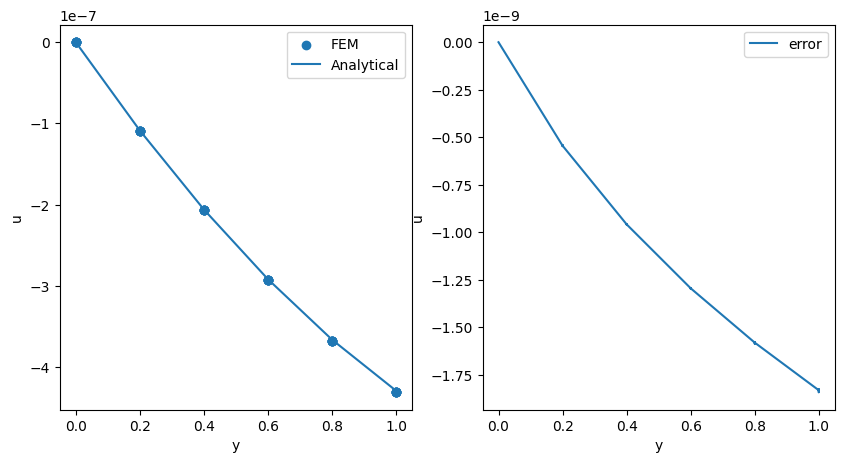

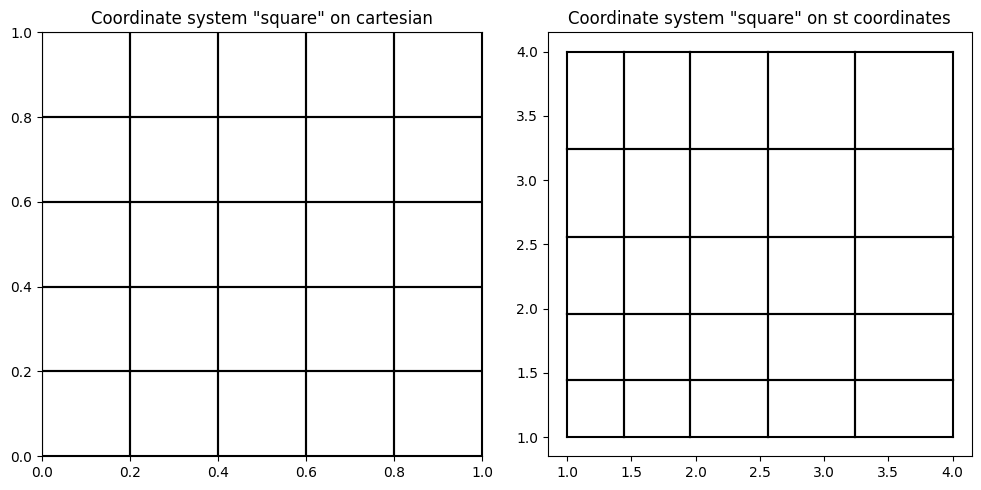

36,5,square,0.0000000015747290
N_divisions=10 N_divisions
1.0236673497296442 4.0
0.011764473447078538 1.0
[[2.02352895 0.        ]
 [0.         4.        ]]
1.105 4.0
0.05118980208143187 1.0
[[2.1023796 0.       ]
 [0.        4.       ]]
1.186332650270356 4.0
0.08918898739858538 1.0
[[2.17837797 0.        ]
 [0.         4.        ]]
1.2359213830372295 4.0
0.11172001108068108 1.0
[[2.22344002 0.        ]
 [0.         4.        ]]
1.3250000000000002 4.0
0.15108644332213395 1.0
[[2.30217289 0.        ]
 [0.         4.        ]]
1.4140786169627706 4.0
0.18915037609327223 1.0
[[2.37830075 0.        ]
 [0.         4.        ]]
1.4681754163448146 4.0
0.21168288604932206 1.0
[[2.42336577 0.        ]
 [0.         4.        ]]
1.565 4.0
0.2509996003196804 1.0
[[2.5019992 0.       ]
 [0.        4.       ]]
1.6618245836551855 4.0
0.28911775399114936 1.0
[[2.57823551 0.        ]
 [0.         4.        ]]
1.7204294496523997 4.0
0.3116514207869405 1.0
[[2.62330284 0.        ]
 [0.         4.        ]

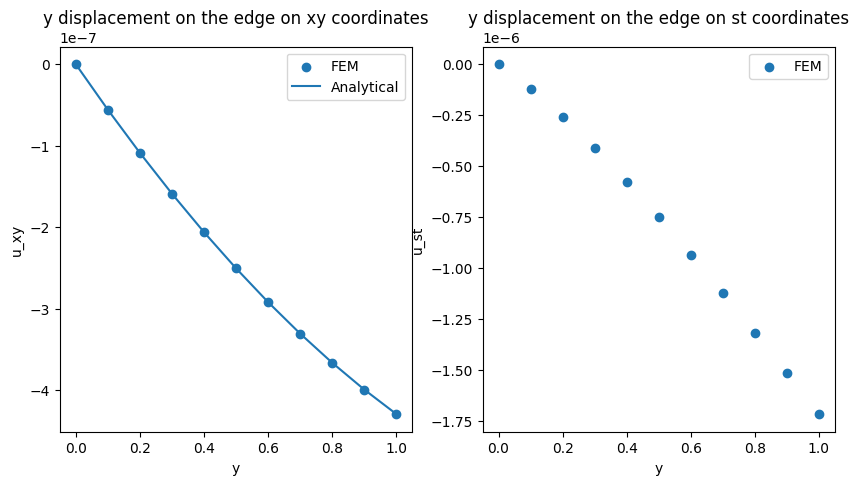

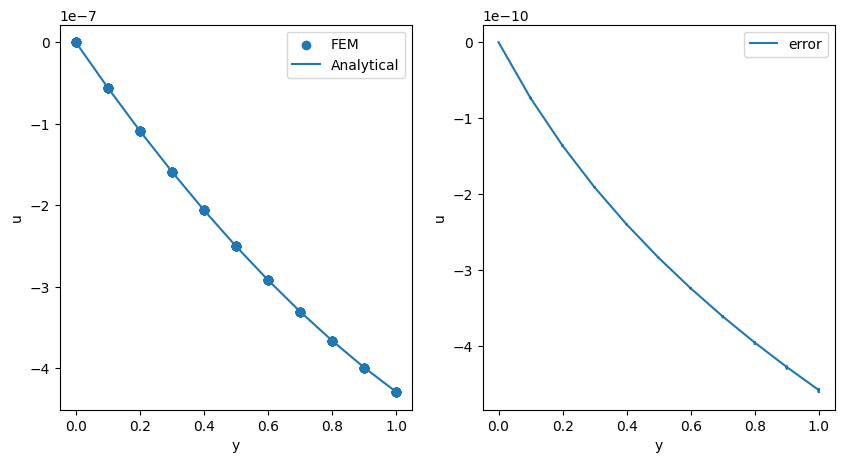

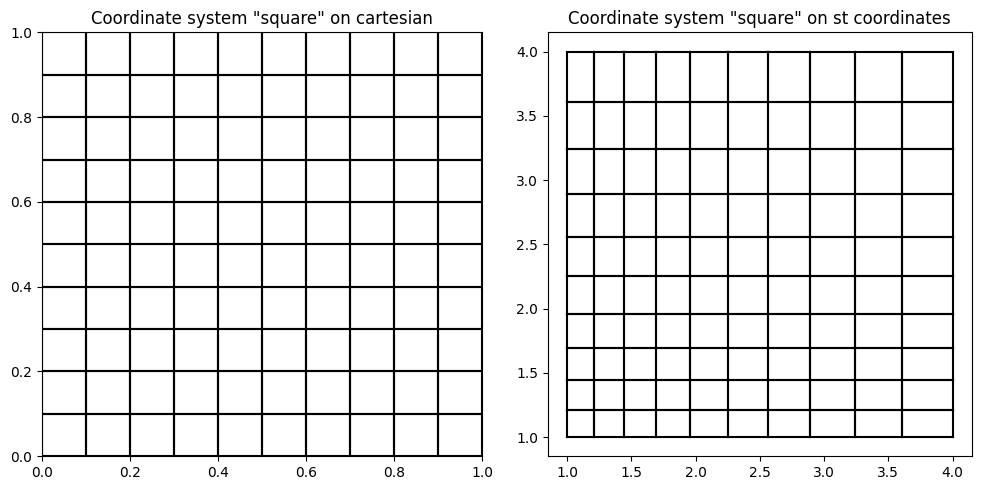

121,10,square,0.0000000003943199
N_divisions=20 N_divisions
1.011551920701374 4.0
0.005759375149629875 1.0
[[2.01151875 0.        ]
 [0.         4.        ]]
1.05125 4.0
0.025304832720493886 1.0
[[2.05060967 0.        ]
 [0.         4.        ]]
1.090948079298626 4.0
0.04448459983794195 1.0
[[2.0889692 0.       ]
 [0.        4.       ]]
1.1146154290282704 4.0
0.055753488759696435 1.0
[[2.11150698 0.        ]
 [0.         4.        ]]
1.15625 4.0
0.07529065838032833 1.0
[[2.15058132 0.        ]
 [0.         4.        ]]
1.1978845709717298 4.0
0.09447913226873816 1.0
[[2.18895826 0.        ]
 [0.         4.        ]]
1.2226789373551668 4.0
0.10574813468310529 1.0
[[2.21149627 0.        ]
 [0.         4.        ]]
1.2662499999999999 4.0
0.12527774349268994 1.0
[[2.25055549 0.        ]
 [0.         4.        ]]
1.3098210626448332 4.0
0.1444741424098812 1.0
[[2.28894828 0.        ]
 [0.         4.        ]]
1.3357424456820626 4.0
0.15574324384011118 1.0
[[2.31148649 0.        ]
 [0.        

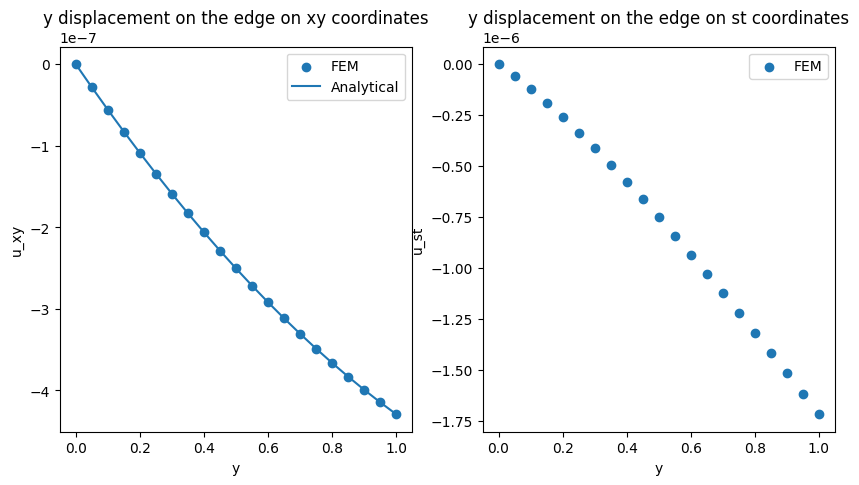

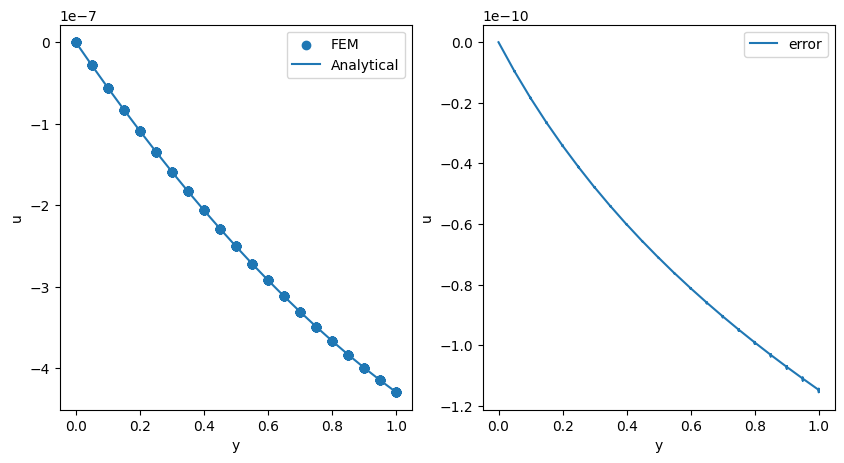

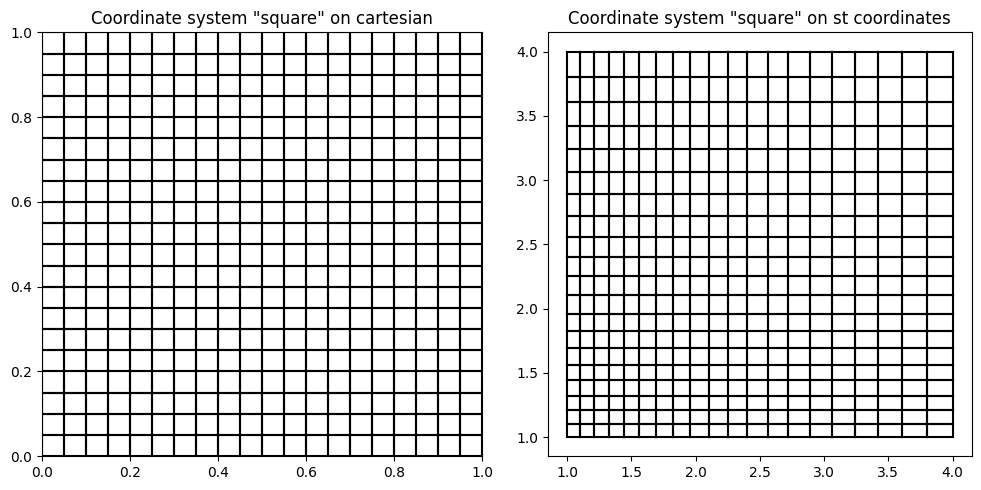

441,20,square,0.0000000000986192
N_divisions=30 N_divisions
1.0076386684312608 4.0
0.0038120682833320263 1.0
[[2.00762414 0.        ]
 [0.         4.        ]]
1.0338888888888889 4.0
0.016803269511309615 1.0
[[2.03360654 0.        ]
 [0.         4.        ]]
1.0601391093465171 4.0
0.029630569353162217 1.0
[[2.05926114 0.        ]
 [0.         4.        ]]
1.075666894354326 4.0
0.03714362281909911 1.0
[[2.07428725 0.        ]
 [0.         4.        ]]
1.1027777777777779 4.0
0.05013226680155758 1.0
[[2.10026453 0.        ]
 [0.         4.        ]]
1.1298886612012298 4.0
0.06296221061768215 1.0
[[2.12592442 0.        ]
 [0.         4.        ]]
1.1459173424996132 4.0
0.07047528813121762 1.0
[[2.14095058 0.        ]
 [0.         4.        ]]
1.173888888888889 4.0
0.08346153087633379 1.0
[[2.16692306 0.        ]
 [0.         4.        ]]
1.2018604352781648 4.0
0.09629395477589164 1.0
[[2.19258791 0.        ]
 [0.         4.        ]]
1.2183900128671228 4.0
0.10380705418434566 1.0
[[2.20761

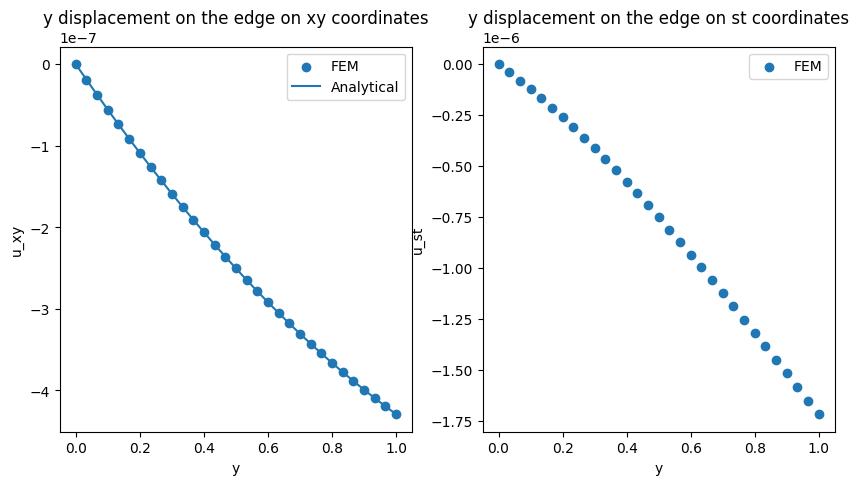

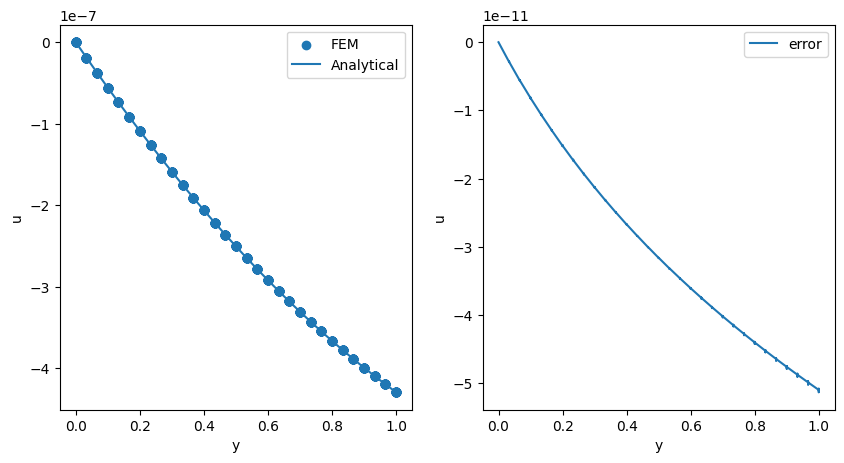

961,30,square,0.0000000000438340
N_divisions=40 N_divisions
1.005705521809825 4.0
0.002848703349525694 1.0
[[2.00569741 0.        ]
 [0.         4.        ]]
1.0253125 4.0
0.01257715755393174 1.0
[[2.02515432 0.        ]
 [0.         4.        ]]
1.044919478190175 4.0
0.022213029749755808 1.0
[[2.04442606 0.        ]
 [0.         4.        ]]
1.0564713988915488 4.0
0.02784794541388691 1.0
[[2.05569589 0.        ]
 [0.         4.        ]]
1.0765625 4.0
0.037575298472356744 1.0
[[2.0751506 0.       ]
 [0.        4.       ]]
1.096653601108451 4.0
0.047212299922251066 1.0
[[2.0944246 0.       ]
 [0.        4.       ]]
1.1084872759732731 4.0
0.05284722347227233 1.0
[[2.10569445 0.        ]
 [0.         4.        ]]
1.1290624999999999 4.0
0.06257352686767037 1.0
[[2.12514705 0.        ]
 [0.         4.        ]]
1.1496377240267268 4.0
0.07221160412799432 1.0
[[2.14442321 0.        ]
 [0.         4.        ]]
1.1617531530549972 4.0
0.07784653502017491 1.0
[[2.15569307 0.        ]
 [0.       

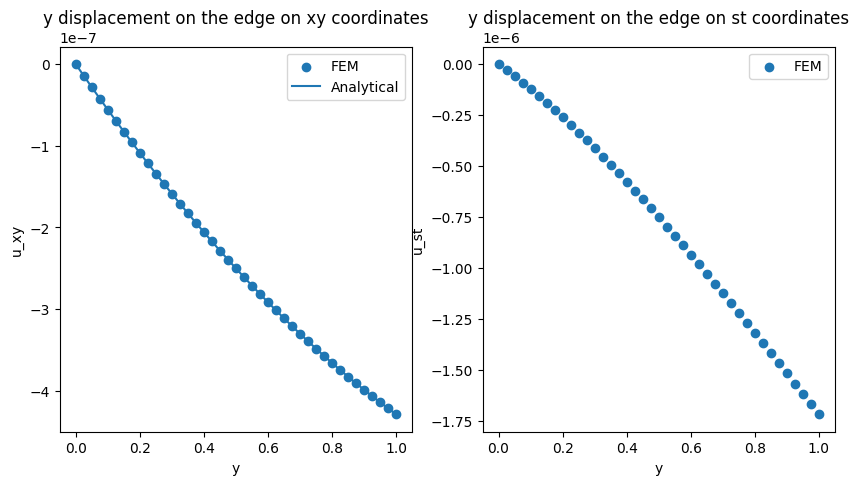

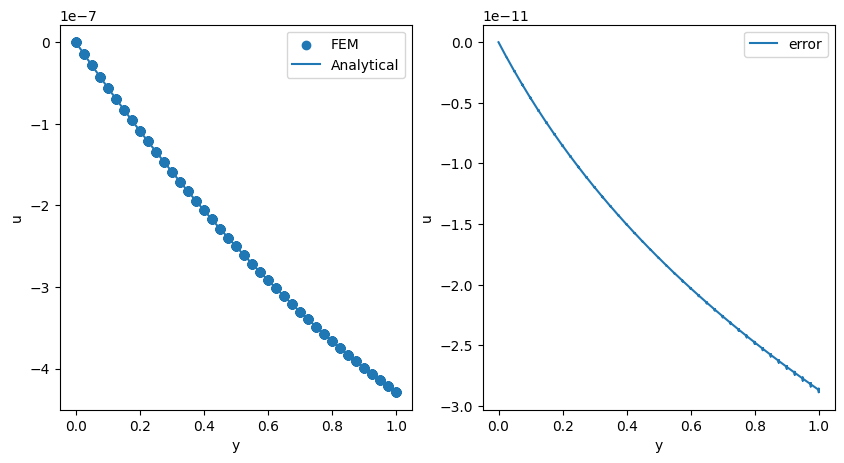

1681,40,square,0.0000000000246573
N_divisions=50 N_divisions
1.004553147281322 4.0
0.00227398812965407 1.0
[[2.00454798 0.        ]
 [0.         4.        ]]
1.0202 4.0
0.010049503737316723 1.0
[[2.02009901 0.        ]
 [0.         4.        ]]
1.035846852718678 4.0
0.017765617771929865 1.0
[[2.03553124 0.        ]
 [0.         4.        ]]
1.0450433086136255 4.0
0.022273597728917904 1.0
[[2.0445472 0.       ]
 [0.        4.       ]]
1.061 4.0
0.030048542545447088 1.0
[[2.06009709 0.        ]
 [0.         4.        ]]
1.0769566913863746 4.0
0.03776523905282869 1.0
[[2.07553048 0.        ]
 [0.         4.        ]]
1.086333469945929 4.0
0.04227322231069963 1.0
[[2.08454644 0.        ]
 [0.         4.        ]]
1.1026000000000002 4.0
0.05004761796787105 1.0
[[2.10009524 0.        ]
 [0.         4.        ]]
1.1188665300540712 4.0
0.05776487465507718 1.0
[[2.11552975 0.        ]
 [0.         4.        ]]
1.1284236312782323 4.0
0.062272861028762394 1.0
[[2.12454572 0.        ]
 [0.        

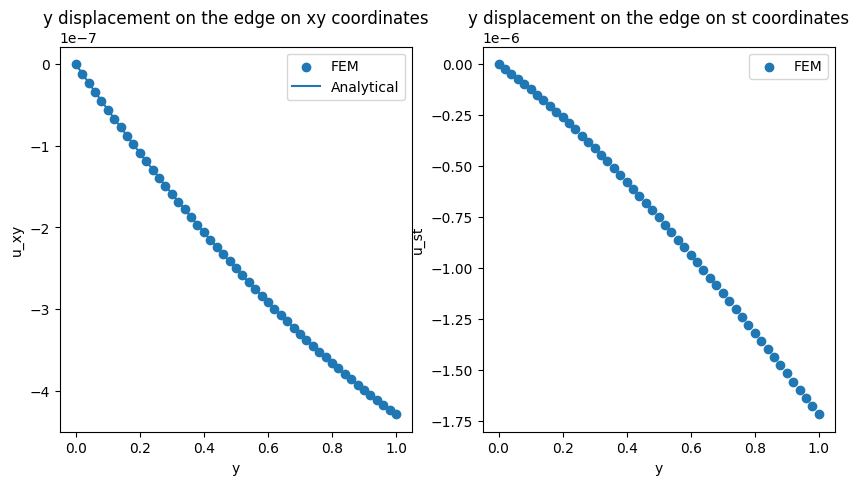

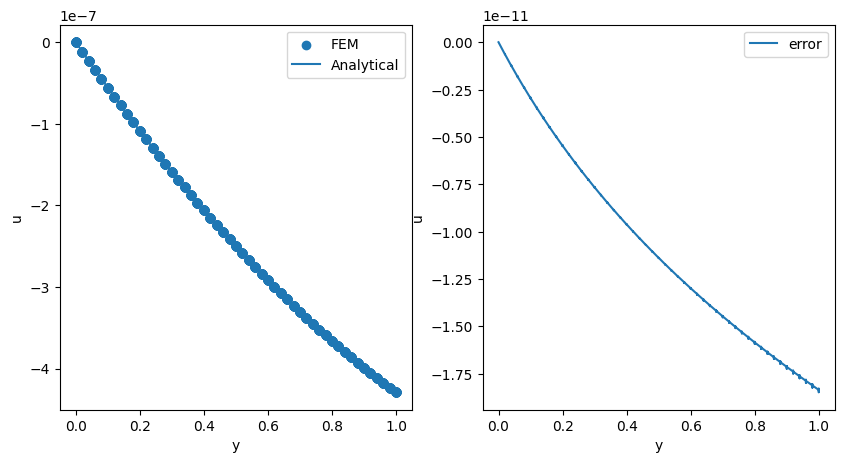

2601,50,square,0.0000000000157808
N_divisions=70 N_divisions
1.003243047922138 4.0
0.0016202114185486227 1.0
[[2.00324042 0.        ]
 [0.         4.        ]]
1.0143877551020406 4.0
0.007168186105002361 1.0
[[2.01433637 0.        ]
 [0.         4.        ]]
1.0255324622819435 4.0
0.012685766801303178 1.0
[[2.02537153 0.        ]
 [0.         4.        ]]
1.0320645588059658 4.0
0.015905782445382988 1.0
[[2.03181156 0.        ]
 [0.         4.        ]]
1.0433673469387754 4.0
0.021453546148220815 1.0
[[2.04290709 0.        ]
 [0.         4.        ]]
1.0546701350715848 4.0
0.026971340920273645 1.0
[[2.05394268 0.        ]
 [0.         4.        ]]
1.0612942329551003 4.0
0.030191357445353617 1.0
[[2.06038271 0.        ]
 [0.         4.        ]]
1.0727551020408161 4.0
0.03573891596329237 1.0
[[2.07147783 0.        ]
 [0.         4.        ]]
1.0842159711265322 4.0
0.04125691888531158 1.0
[[2.08251384 0.        ]
 [0.         4.        ]]
1.090932070369541 4.0
0.044476936255435584 1.0
[[2

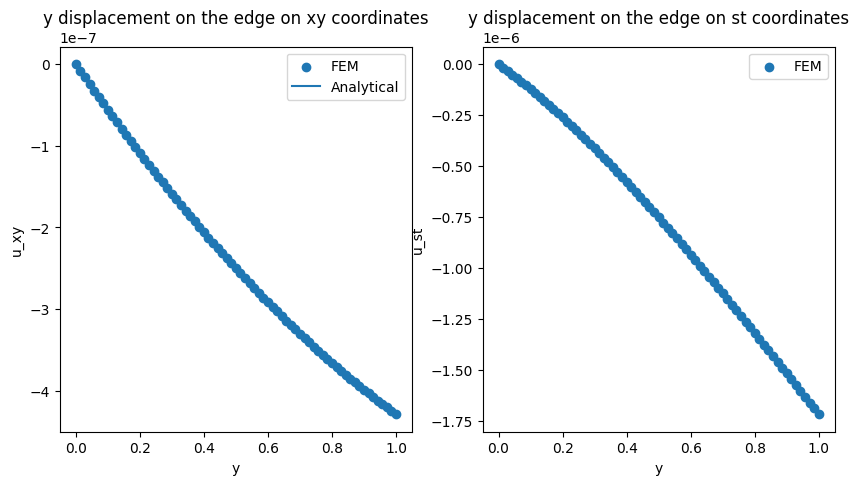

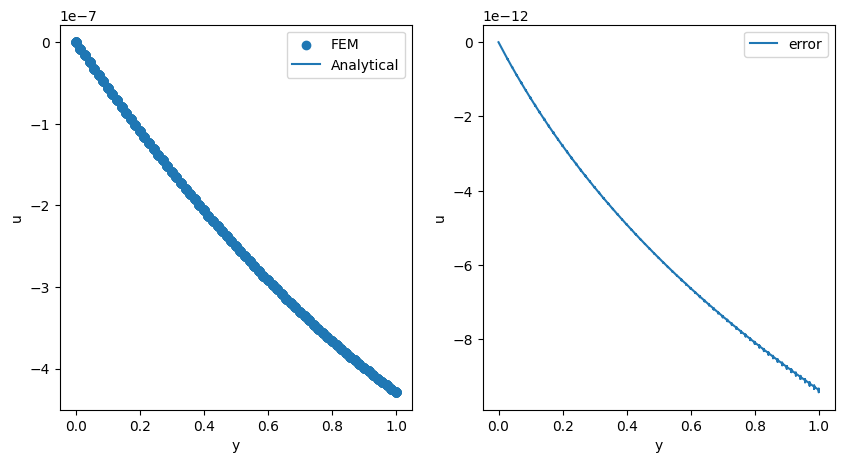

5041,70,square,0.0000000000080515
N_divisions=100 N_divisions
1.0022653034741231 4.0
0.001132011012595191 1.0
[[2.00226402 0.        ]
 [0.         4.        ]]
1.0100500000000001 4.0
0.005012437733981523 1.0
[[2.01002488 0.        ]
 [0.         4.        ]]
1.0178346965258769 4.0
0.008877939359304587 1.0
[[2.01775588 0.        ]
 [0.         4.        ]]
1.022387843807199 4.0
0.011131961618857655 1.0
[[2.02226392 0.        ]
 [0.         4.        ]]
1.03025 4.0
0.015012315196224701 1.0
[[2.03002463 0.        ]
 [0.         4.        ]]
1.038112156192801 4.0
0.018877890717430956 1.0
[[2.03775578 0.        ]
 [0.         4.        ]]
1.0427103841402747 4.0
0.0211319131925487 1.0
[[2.04226383 0.        ]
 [0.         4.        ]]
1.05065 4.0
0.025012195049405328 1.0
[[2.05002439 0.        ]
 [0.         4.        ]]
1.0585896158597252 4.0
0.028877843021087424 1.0
[[2.05775569 0.        ]
 [0.         4.        ]]
1.0632329244733507 4.0
0.031131865705521955 1.0
[[2.06226373 0.        ]


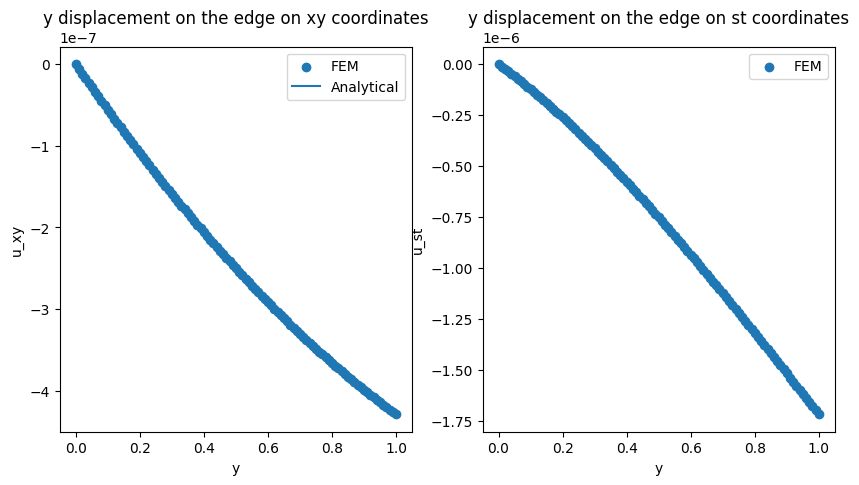

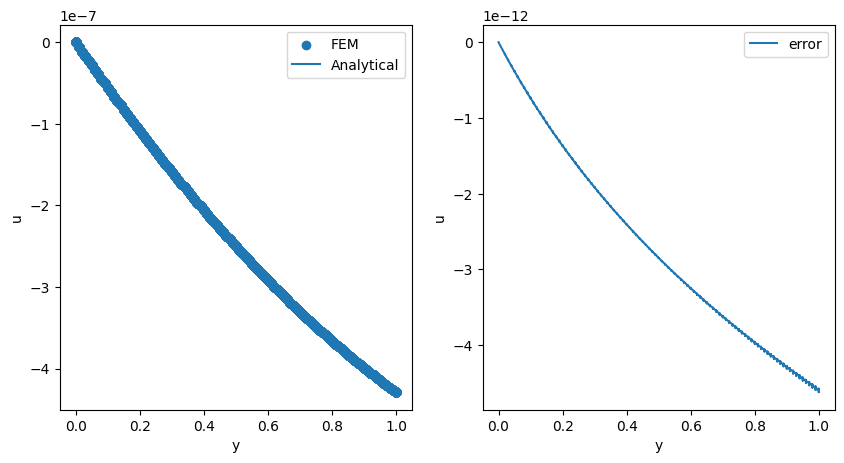

10201,100,square,0.0000000000039453
alpha.name='cube' transformation
N_divisions=5 N_divisions
1.0820468123961 8.0
0.026633307122129635 1.0
[[ 3.16192784  0.        ]
 [ 0.         12.        ]]
1.3639999999999999 8.0
0.10901679567954559 1.0
[[ 3.68975476  0.        ]
 [ 0.         12.        ]]
1.6459531876038997 8.0
0.18069890311558212 1.0
[[ 4.1821497  0.       ]
 [ 0.        12.       ]]
1.8425048920253262 8.0
0.22594094403700904 1.0
[[ 4.50879359  0.        ]
 [ 0.         12.        ]]
2.2359999999999998 8.0
0.30764723471653554 1.0
[[ 5.12982387  0.        ]
 [ 0.         12.        ]]
2.629495107974673 8.0
0.3802490462752346 1.0
[[ 5.71526229  0.        ]
 [ 0.         12.        ]]
2.8963726515927566 8.0
0.4254483294930522 1.0
[[ 6.09570882  0.        ]
 [ 0.         12.        ]]
3.42 8.0
0.5066372545837328 1.0
[[ 6.80986745  0.        ]
 [ 0.         12.        ]]
3.9436273484072437 8.0
0.5799085761883249 1.0
[[ 7.48833333  0.        ]
 [ 0.         12.        ]]
4.2916500910

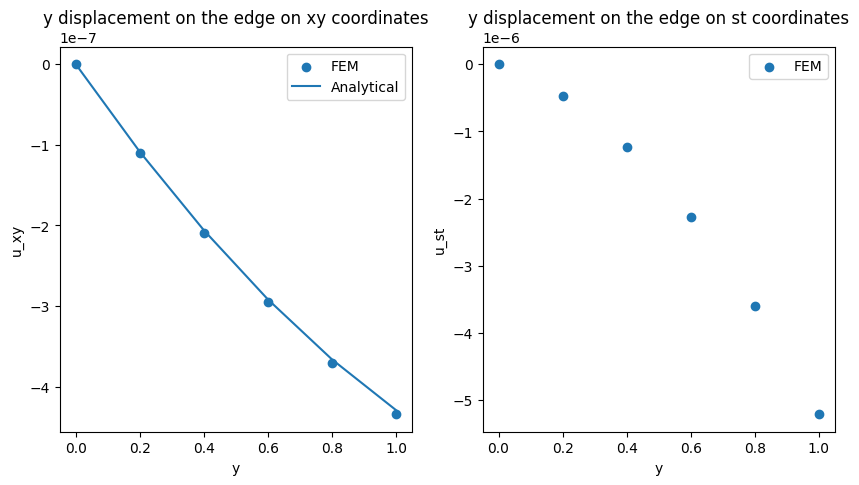

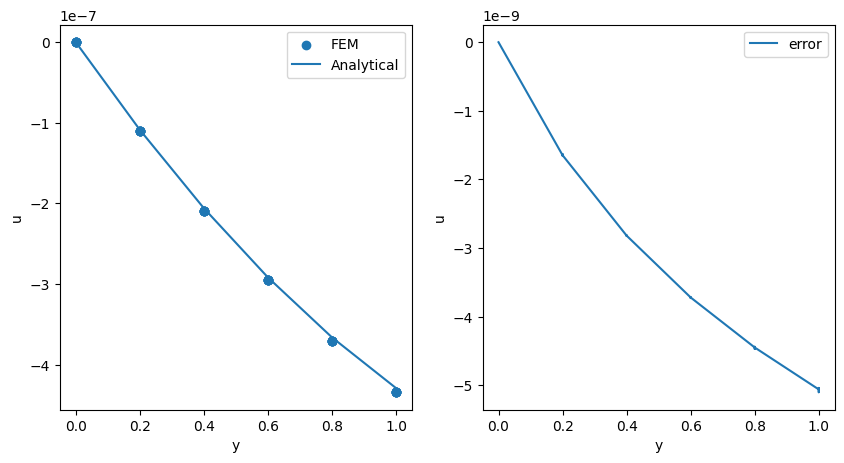

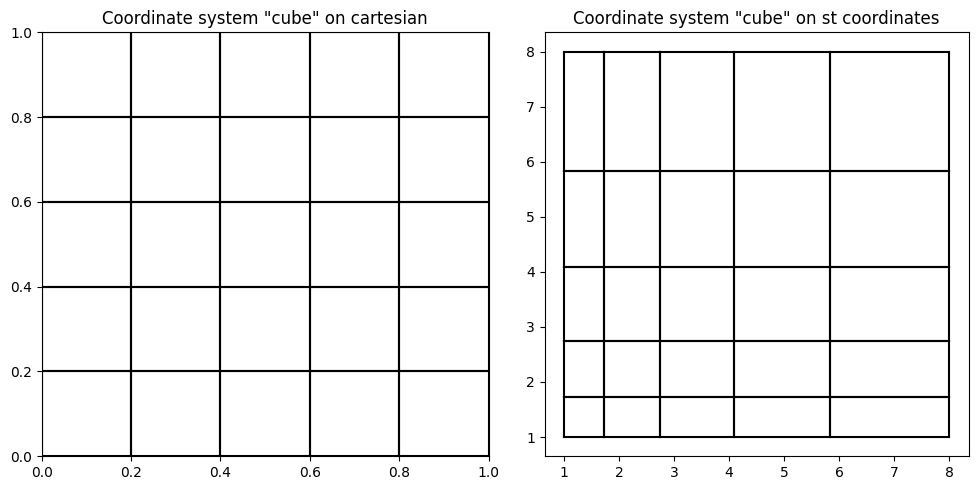

36,5,cube,0.0000000026030459
N_divisions=10 N_divisions
1.0373042512405346 8.0
0.012283254317880576 1.0
[[ 3.07415216  0.        ]
 [ 0.         12.        ]]
1.1655000000000002 8.0
0.05237557370821144 1.0
[[ 3.32248304  0.        ]
 [ 0.         12.        ]]
1.2936957487594658 8.0
0.08962581459577845 1.0
[[ 3.56185325  0.        ]
 [ 0.         12.        ]]
1.3757425611555658 8.0
0.11219018395511404 1.0
[[ 3.71090102  0.        ]
 [ 0.         12.        ]]
1.5295 8.0
0.15216981646558891 1.0
[[ 3.98248586  0.        ]
 [ 0.         12.        ]]
1.6832574388444344 8.0
0.18955222633635516 1.0
[[ 4.2451035  0.       ]
 [ 0.        12.       ]]
1.7808570810628719 8.0
0.2121127582879867 1.0
[[ 4.40765202  0.        ]
 [ 0.         12.        ]]
1.9625 8.0
0.2519968085061224 1.0
[[ 4.70248803  0.        ]
 [ 0.         12.        ]]
2.1441429189371277 8.0
0.2894897966227923 1.0
[[ 4.98835181  0.        ]
 [ 0.         12.        ]]
2.2586478109624544 8.0
0.31204734171686677 1.0
[[ 5.1644

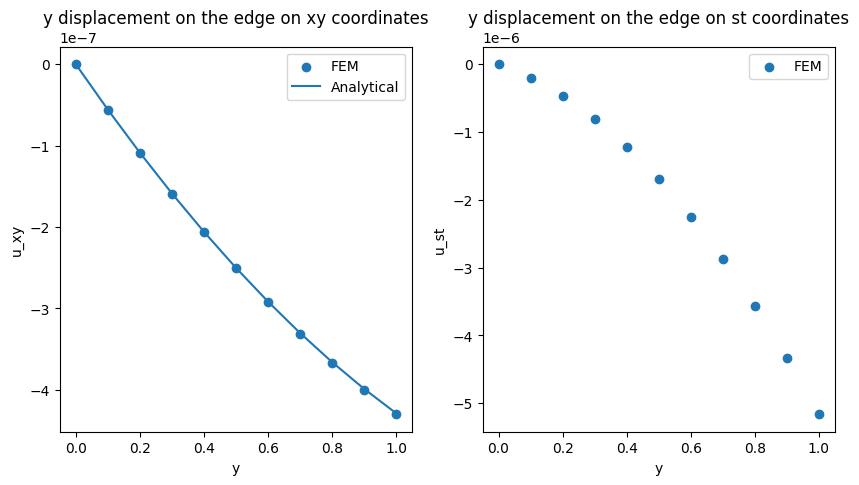

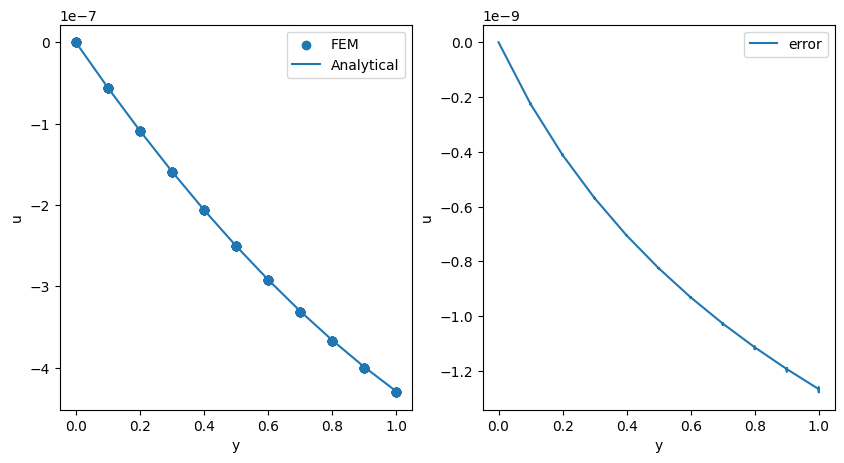

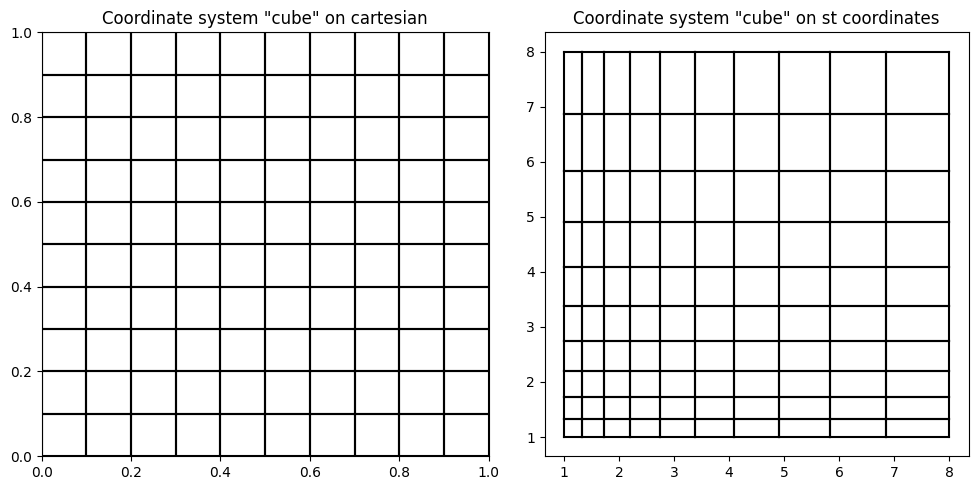

121,10,cube,0.0000000006537929
N_divisions=20 N_divisions
1.0177646000054057 8.0
0.0058868107922553925 1.0
[[ 3.03542483  0.        ]
 [ 0.         12.        ]]
1.0788125000000002 8.0
0.025609393722630047 1.0
[[ 3.15562389  0.        ]
 [ 0.         12.        ]]
1.1398603999945944 8.0
0.044601284058890744 1.0
[[ 3.27357553  0.        ]
 [ 0.         12.        ]]
1.177164651235129 8.0
0.055874749369402954 1.0
[[ 3.34461446  0.        ]
 [ 0.         12.        ]]
1.2443125000000004 8.0
0.07558108119423901 1.0
[[ 3.47062399  0.        ]
 [ 0.         12.        ]]
1.3114603487648715 8.0
0.09459061829103255 1.0
[[ 3.59438586  0.        ]
 [ 0.         12.        ]]
1.3523992287138868 8.0
0.10586379056794959 1.0
[[ 3.66880417  0.        ]
 [ 0.         12.        ]]
1.4259375 8.0
0.12555528143271144 1.0
[[ 3.80062407  0.        ]
 [ 0.         12.        ]]
1.4994757712861133 8.0
0.14458087322075275 1.0
[[ 3.93019613  0.        ]
 [ 0.         12.        ]]
1.5442183324416787 8.0
0.1558

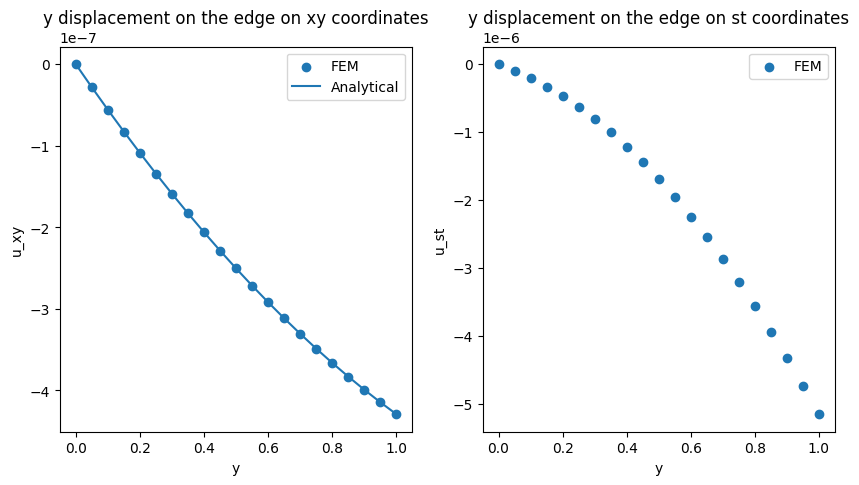

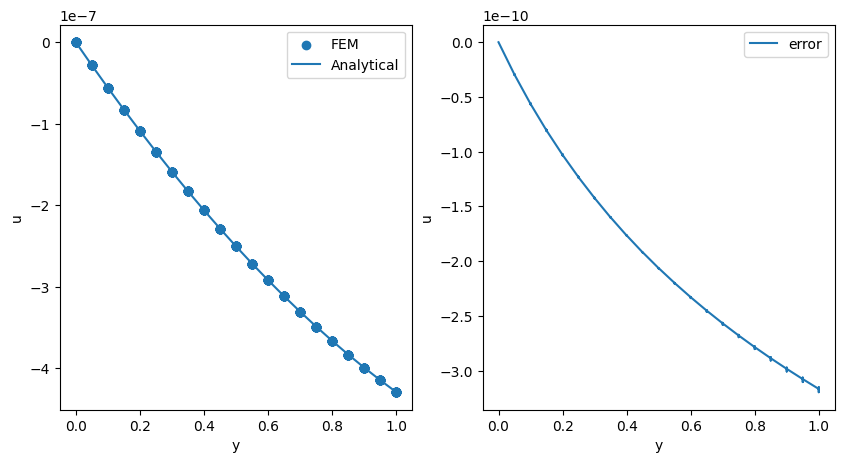

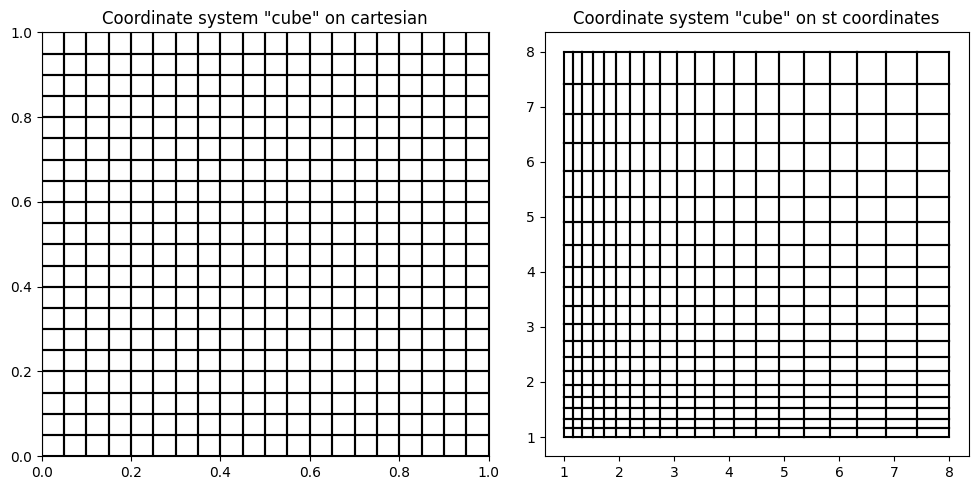

441,20,cube,0.0000000001636491
N_divisions=30 N_divisions


In [67]:
for alpha in alphas:
    print(f'{alpha.name=} transformation')
    #for N_divisions in [5,10,20,30,40,50]:
    # if alpha.name!="Xlinear-Ysquare1_01":
    #     continue
    for N_divisions in [5,10,20,30,40,50,70,100]:
        print(f'{N_divisions=} N_divisions')
        run(N_divisions,alpha,H_total=H_total)